<a href="https://colab.research.google.com/github/thomaslu678/gee-test/blob/main/clean/4_create_sine_fit_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: Requires export_clean.csv (cleaned up export CSV with sorts and time columns)

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point
import requests

# Read cleaned up export csv

In [3]:
export_clean_df = pd.read_csv('/content/sample_data/export_clean.csv')

# Build sine df

In [4]:
sine_columns = ["lat", "long", "year", "A", "f", "phi", "C"]

In [5]:
sine_df = pd.DataFrame(columns=sine_columns)

## Populate rows of sine df.
Duration: (15 min/n5), (6 min/n10)

In [7]:
def sine_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

In [33]:
def populate_rows(rows, min_count):
    runtime_error_count = 0
    coordinate_count = 0
    for (lat, lon), coord_df in export_clean_df.groupby(['lat', 'long']):
        # Uncomment and use for progress
        if (coordinate_count % 100 == 0):
            print(coordinate_count)
        for year, year_df in coord_df.groupby('year'):
            # need enough points to fit a sine, 5 points chosen arbitrarily
            if len(year_df) < min_count:
                continue

            test_values = year_df['LST_K'].to_numpy()
            test_dates = np.array([datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') for date_str in year_df['time'].to_numpy()], dtype=object)

            # convert time to days since first observation
            t0 = test_dates[0]
            t = np.array(
                [(d - t0).total_seconds() / 86400 for d in test_dates]
            )

            # initial guesses
            A_guess = (test_values.max() - test_values.min()) / 2
            C_guess = test_values.mean()
            f_guess = 1 / 365
            phi_guess = 0
            p0 = [A_guess, f_guess, phi_guess, C_guess]

            try:
                params, cov = curve_fit(
                    sine_model,
                    t,
                    test_values,
                    p0=p0
                )

                A, f, phi, C = params

                rows.append({
                    "lat": lat,
                    "long": lon,
                    "year": year,
                    "A": A,
                    "f": f,
                    "phi": phi,
                    "C": C
                })

            except RuntimeError:
                # fit failed — skip this year
                runtime_error_count += 1
                continue
        coordinate_count += 1

In [34]:
rows = []  # collect rows first (much faster than appending to df)
min_count = 5
populate_rows(rows, min_count)
sine_df = pd.DataFrame(rows)

0
100
200
300
400
500
600
700
800
900
1000


/tmp/ipython-input-3087514124.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(


1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600


In [36]:
sine_df

,lat,long,year,A,f,phi,C
0,37.565193,126.987004,1989,19.869800,0.003109,-1.357817,301.748036
1,37.565193,126.987004,1990,21.411413,0.002333,-1.020308,288.478514
2,37.565193,126.987004,1991,19.181576,0.003180,-0.993718,296.916165
3,37.565193,126.987004,1992,18.053384,0.002626,-1.699192,294.121845
4,37.565193,126.987004,1993,240.361605,0.000613,1.028081,69.397060
...,...,...,...,...,...,...,...
151689,37.574882,127.041636,2021,24.414483,0.002203,5.248312,289.834540
151690,37.574882,127.041636,2022,37.725811,0.001623,-0.284917,275.273167
151691,37.574882,127.041636,2023,21.067508,0.002452,-1.030775,292.311670
151692,37.574882,127.041636,2024,22.473501,0.002433,-1.175560,295.178531


In [45]:
sine_df.to_csv(f"/content/sample_data/sine_years_n{min_count}_improved.csv", index=False)

# Lin_reg part 2

In [61]:
sine_df_n5_original = pd.read_csv('/content/sample_data/sine_years_n5.csv')

In [46]:
sine_df_n5 = pd.read_csv('/content/sample_data/sine_years_n5_improved.csv')

In [67]:
export_clean_df

,system:index,LST_K,distance,image_id,lat,long,mission,time,.geo,year
0,1_LT05_116034_19840730_797_0,314.209997,326.113118,LT05_116034_19840730,37.565193,126.987004,L5,1984-07-30 01:40:17,"{""type"":""MultiPoint"",""coordinates"":[]}",1984
1,1_LT05_116034_19850311_797_0,278.949702,326.113118,LT05_116034_19850311,37.565193,126.987004,L5,1985-03-11 01:41:28,"{""type"":""MultiPoint"",""coordinates"":[]}",1985
2,1_LT05_116034_19860226_797_0,271.963270,326.113118,LT05_116034_19860226,37.565193,126.987004,L5,1986-02-26 01:37:29,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
3,1_LT05_116034_19860415_797_0,300.356762,326.113118,LT05_116034_19860415,37.565193,126.987004,L5,1986-04-15 01:36:29,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
4,1_LT05_116034_19860517_797_0,302.188820,326.113118,LT05_116034_19860517,37.565193,126.987004,L5,1986-05-17 01:35:40,"{""type"":""MultiPoint"",""coordinates"":[]}",1986
...,...,...,...,...,...,...,...,...,...,...
2644639,3_LC08_116034_20251104_4458_0,290.868338,325.944916,LC08_116034_20251104,37.574882,127.041636,L8,2025-11-04 02:11:21,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644640,4_LC09_116034_20251112_4458_0,290.212078,325.944916,LC09_116034_20251112,37.574882,127.041636,L9,2025-11-12 02:11:26,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644641,4_LC09_116034_20251128_4458_0,281.089383,325.944916,LC09_116034_20251128,37.574882,127.041636,L9,2025-11-28 02:11:24,"{""type"":""MultiPoint"",""coordinates"":[]}",2025
2644642,3_LC08_116034_20251222_4458_0,274.424244,325.944916,LC08_116034_20251222,37.574882,127.041636,L8,2025-12-22 02:11:18,"{""type"":""MultiPoint"",""coordinates"":[]}",2025


# Graph helper function

In [122]:
def graph_sine_against_data(X, y, A, f, phi, C):

    dates = np.array(X)
    values = np.array(y, dtype=float)

    mask = ~np.isnan(values)   # None → NaN when cast to float
    dates_fit = dates[mask]
    values_fit = values[mask]

    t0 = dates_fit[0]

    # Dense grid of datetimes
    dates_dense = np.array([
        dates_fit.min() + timedelta(seconds=s)
        for s in np.linspace(
            0,
            (dates_fit.max() - dates_fit.min()).total_seconds(),
            1000
        )
    ])

    t_dense = np.array([(d - t0).total_seconds() / 86400 for d in dates_dense])
    y_fit = sine_model(t_dense, A, f, phi, C)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Original data
    ax.scatter(X, y,
              color='tab:blue', label='Data')

    # Fitted sine curve
    ax.plot(dates_dense, y_fit,
            color='tab:red', linewidth=2, label='Sine fit')

    # Formatting
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

    ax.set_xlabel("Time")
    ax.set_ylabel("Raw Values")
    ax.set_title("Time Series with Sine Fit")
    ax.legend()

    plt.show()

In [125]:
def graph_sine_fit_data(lat, long, year, export_clean_df, sine_df_fit):
    lat_filter, long_filter, year_filter = lat, long, year
    bad_mask = (export_clean_df['lat'] == lat_filter) & (export_clean_df['long'] == long_filter) & (export_clean_df['year'] == year_filter)
    bad_data = export_clean_df[bad_mask]
    X = pd.to_datetime(bad_data['time'].to_numpy().tolist()).to_pydatetime()
    y = bad_data['LST_K'].to_numpy().tolist()

    sine_mask = (sine_df_fit['lat'] == lat_filter) & (sine_df_fit['long'] == long_filter) & (sine_df_fit['year'] == year_filter)
    sine_masked_data = sine_df_fit[sine_mask]
    # fitted parameters
    A = sine_masked_data.iloc[0]['A']
    f = sine_masked_data.iloc[0]['f']
    phi = sine_masked_data.iloc[0]['phi']
    C = sine_masked_data.iloc[0]['C']

    graph_sine_against_data(X, y, A, f, phi, C)

    # print(f"{year}: {C}, {f}, {phi}, {A}")
    # plt.scatter(bad_data['time'], bad_data['LST_K'])
    # plt.ylim(250,
    #         350)
    # plt.show()

    # plt.title(f"{year}: {C}")
    # plt.scatter(bad_data['time'], bad_data['LST_K'])
    # plt.plot(t_fit, y_fit, color="red", linewidth=2, label="Sine fit")
    # plt.ylim(250,
    #         350)
    # plt.show()

    # plt.title(C)
    # plt.scatter(bad_data['time'], bad_data['LST_K'])
    # plt.plot(t_fit, y_fit, color="red", linewidth=2, label="Sine fit")

    # ax = plt.gca() # Get the current axes
    # ax.relim()     # Recompute the data limits
    # ax.autoscale(axis='y')

    # plt.show()

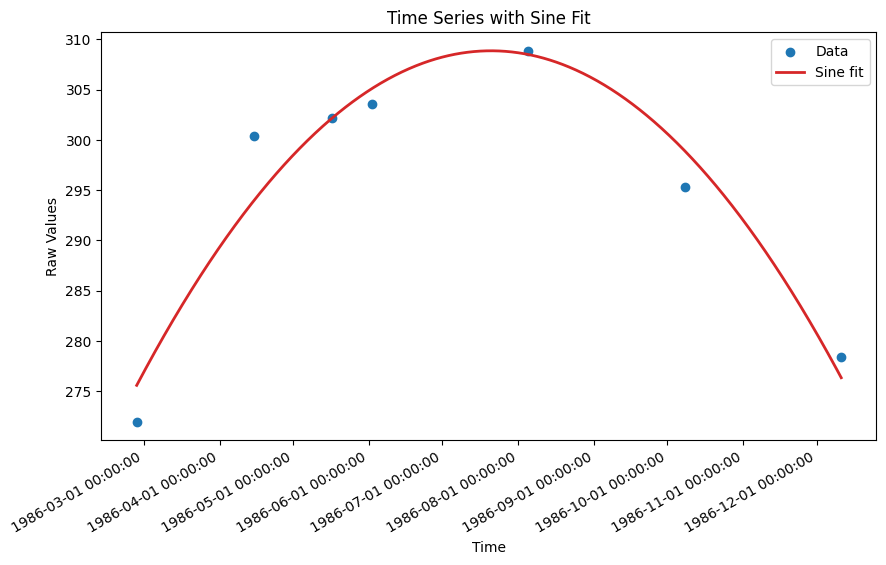

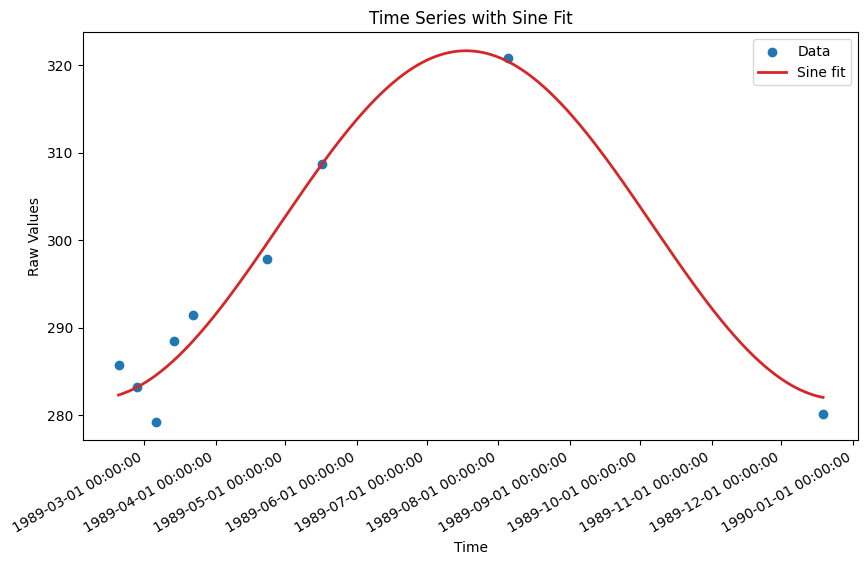

In [129]:
index = 0
lat, long, year = sine_df_n5_original.iloc[index]['lat'], sine_df_n5_original.iloc[index]['long'], sine_df_n5_original.iloc[index]['year']
graph_sine_fit_data(lat, long, year, export_clean_df, sine_df_n5_original)

lat, long, year = sine_df_n5.iloc[index]['lat'], sine_df_n5.iloc[index]['long'], sine_df_n5.iloc[index]['year']
graph_sine_fit_data(lat, long, year, export_clean_df, sine_df_n5)

# Prepare lin reg df

In [ ]:
columns = ['lat', 'long', 'm', 'b', 'r^2']
linreg_df_n5 = pd.DataFrame(columns=columns)

In [ ]:
# Group by coordinate
count = 0
for (lat, lon), group in sine_df_n5.groupby(['lat', 'long']):

    if (count % 100 == 0):
        print(count)
    # Remove outliers based on C
    # group_clean = remove_outliers_iqr(group, 'C')

    # Need at least 2 points for linear regression
    if len(group) < 2:
        continue

    x = group['year'].values
    y = group['C'].values

    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Store results
    linreg_df_n5.loc[len(linreg_df_n5)] = [
        lat,
        lon,
        slope,
        intercept,
        r_value ** 2
    ]

    count += 1

In [ ]:
linreg_df_n5

In [ ]:
linreg_df_n5.to_csv("/content/sample_data/linreg_n5.csv", index=False)

# Export to .tif

In [ ]:
gdf = gpd.GeoDataFrame(
    linreg_df_n5,
    geometry=gpd.points_from_xy(
        linreg_df_n5['long'],
        linreg_df_n5['lat']
    ),
    crs="EPSG:4326"
)

gdf_5179 = gdf.to_crs("EPSG:5179")

In [ ]:
pixel_size = 30  # meters

xmin, ymin, xmax, ymax = gdf_5179.total_bounds

width = int((xmax - xmin) / pixel_size) + 1
height = int((ymax - ymin) / pixel_size) + 1

transform = from_origin(xmin, ymax, pixel_size, pixel_size)

In [ ]:
shapes = (
    (geom, value)
    for geom, value in zip(gdf_5179.geometry, gdf_5179['m'])
)

raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32"
)

In [ ]:
path = "/content/sample_data/linreg_n5.tif"

with rasterio.open(
    path,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs="EPSG:5179",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(raster, 1)